<a href="https://colab.research.google.com/github/Imronrsya/CERN-Electron-Collision-Data/blob/main/CERN_Electron_Collision_Data_Tubes_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

#Import Library

In [20]:
# Install Library
!pip install -q kagglehub xgboost

# Basic Tools
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# KaggleHub (download dataset)
import kagglehub

# Preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Dataset

In [21]:
# Download Dataset
path = kagglehub.dataset_download("fedesoriano/cern-electron-collision-data")
csv_path = f"{path}/dielectron.csv"

# Load Data Asli
df = pd.read_csv(csv_path)

print(f"Dimensi Data Asli (Raw): {df.shape}")
df.head()

Using Colab cache for faster access to the 'cern-electron-collision-data' dataset.
Dimensi Data Asli (Raw): (100000, 19)


,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


#EDA

##4.1 Informasi Dasar

In [22]:
print("="*60)
print("INFORMASI DATASET")
print("="*60)
df.info()

print("\n" + "="*60)
print("CEK KUALITAS DATA")
print("="*60)
print(f"Jumlah Baris          : {len(df):,}")
print(f"Jumlah Kolom          : {len(df.columns)}")
print(f"Baris Duplikat        : {df.duplicated().sum():,}")
print(f"Total Missing Values  : {df.isnull().sum().sum():,}")

if df.isnull().sum().sum() > 0:
    print("\nMissing Values per Kolom:")
    print("-" * 40)
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    for col, count in missing_data.items():
        pct = (count / len(df)) * 100
        print(f"  {col:20s}: {count:6,} ({pct:5.2f}%)")
else:
    print("\nTidak ada missing values dalam dataset.")

print("="*60)

print("\n" + "="*60)
print("STATISTIK DESKRIPTIF")
print("="*60)
display(df.describe().round(4))

print("\n" + "="*60)
print("TIPE DATA")
print("="*60)
dtype_summary = df.dtypes.value_counts()
print(dtype_summary)
print("="*60)

INFORMASI DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   E1      100000 non-null  float64
 3   px1     100000 non-null  float64
 4   py1     100000 non-null  float64
 5   pz1     100000 non-null  float64
 6   pt1     100000 non-null  float64
 7   eta1    100000 non-null  float64
 8   phi1    100000 non-null  float64
 9   Q1      100000 non-null  int64  
 10  E2      100000 non-null  float64
 11  px2     100000 non-null  float64
 12  py2     100000 non-null  float64
 13  pz2     100000 non-null  float64
 14  pt2     100000 non-null  float64
 15  eta2    100000 non-null  float64
 16  phi2    100000 non-null  float64
 17  Q2      100000 non-null  int64  
 18  M       99915 non-null   float64
dtypes: float64(15), int64(4)
memory usage: 14.5 MB

CEK KUALITAS DATA
Jum

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
count,100000.0000,1.000000e+05,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,99915.0000
mean,147935.3272,4.957212e+08,36.4365,0.1359,0.1823,-1.5080,14.4122,-0.0641,0.0216,-0.0055,44.0029,-0.0040,0.1247,-1.5906,13.8020,-0.0728,0.0214,-0.0042,30.0195
std,920.3061,4.037703e+08,41.2162,13.4050,13.4703,51.6037,12.3887,1.4621,1.7996,1.0000,46.7511,13.1274,13.1689,61.4300,12.4605,1.7380,1.8170,1.0000,25.2558
min,146511.0000,6.414000e+03,0.3779,-250.5870,-126.0790,-840.9870,0.2196,-4.1654,-3.1416,-1.0000,0.4725,-233.7300,-145.6510,-655.3960,0.0267,-7.0648,-3.1416,-1.0000,2.0001
25%,147114.0000,2.023970e+08,8.4586,-5.2337,-5.2762,-15.8598,3.7712,-1.2839,-1.5270,-1.0000,11.0557,-4.7948,-4.6060,-22.0369,3.7381,-1.8923,-1.5569,-1.0000,12.4452
50%,147929.0000,3.902759e+08,21.7170,0.1413,0.0991,-0.3130,12.9678,-0.0612,0.0343,-1.0000,25.2646,-0.0356,0.0837,-0.6902,11.6910,-0.1359,0.0270,-1.0000,21.2831
75%,149011.0000,6.338891e+08,50.0034,5.7146,5.6481,13.2126,20.0189,1.1444,1.5624,1.0000,66.9255,4.8195,5.0619,19.0058,19.5964,1.7683,1.5967,1.0000,39.0250
max,149182.0000,1.791247e+09,850.6020,134.5390,147.4670,760.0960,265.5780,2.6230,3.1414,1.0000,948.3750,227.3300,166.2830,935.5580,281.6540,3.0606,3.1413,1.0000,109.9990



TIPE DATA
float64    15
int64       4
Name: count, dtype: int64


##4.2 Analisis Distribusi Target (Invariant Mass)

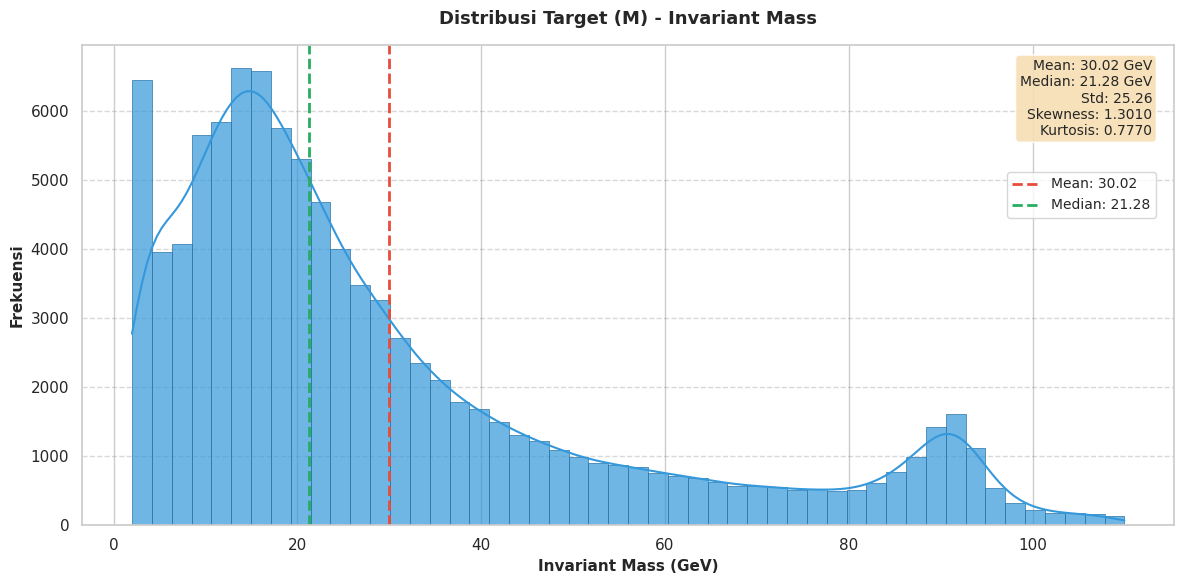


STATISTIK DESKRIPTIF TARGET (M)
Jumlah Data      : 100,000
Mean             : 30.0195 GeV
Median           : 21.2831 GeV
Std Deviation    : 25.2558
Min              : 2.0001 GeV
Max              : 109.9990 GeV
Skewness         : 1.3010
Kurtosis         : 0.7770

Interpretasi Skewness: Distribusi condong ke kanan (right-skewed)


In [23]:
plt.figure(figsize=(12, 6))

sns.histplot(df['M'], kde=True, bins=50, color='#3498DB',
             edgecolor='#2874A6', linewidth=0.5, alpha=0.7)

plt.title("Distribusi Target (M) - Invariant Mass", fontsize=13, fontweight='bold', pad=15)
plt.xlabel("Invariant Mass (GeV)", fontsize=11, fontweight='bold')
plt.ylabel("Frekuensi", fontsize=11, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3, color='gray')
plt.gca().set_axisbelow(True)

skewness = df['M'].skew()
kurtosis = df['M'].kurtosis()
mean_val = df['M'].mean()
median_val = df['M'].median()
std_val = df['M'].std()

stats_text = f"Mean: {mean_val:.2f} GeV\nMedian: {median_val:.2f} GeV\nStd: {std_val:.2f}\nSkewness: {skewness:.4f}\nKurtosis: {kurtosis:.4f}"
plt.text(0.98, 0.97, stats_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

plt.axvline(mean_val, color='#E74C3C', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='#27AE60', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
plt.legend(loc='upper right', fontsize=10, bbox_to_anchor=(0.99, 0.75))

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("STATISTIK DESKRIPTIF TARGET (M)")
print("="*60)
print(f"Jumlah Data      : {len(df['M']):,}")
print(f"Mean             : {mean_val:.4f} GeV")
print(f"Median           : {median_val:.4f} GeV")
print(f"Std Deviation    : {std_val:.4f}")
print(f"Min              : {df['M'].min():.4f} GeV")
print(f"Max              : {df['M'].max():.4f} GeV")
print(f"Skewness         : {skewness:.4f}")
print(f"Kurtosis         : {kurtosis:.4f}")
print("="*60)

if abs(skewness) < 0.5:
    skew_interp = "Distribusi relatif simetris"
elif skewness > 0:
    skew_interp = "Distribusi condong ke kanan (right-skewed)"
else:
    skew_interp = "Distribusi condong ke kiri (left-skewed)"

print(f"\nInterpretasi Skewness: {skew_interp}")

## 4.3 Analisis Korelasi

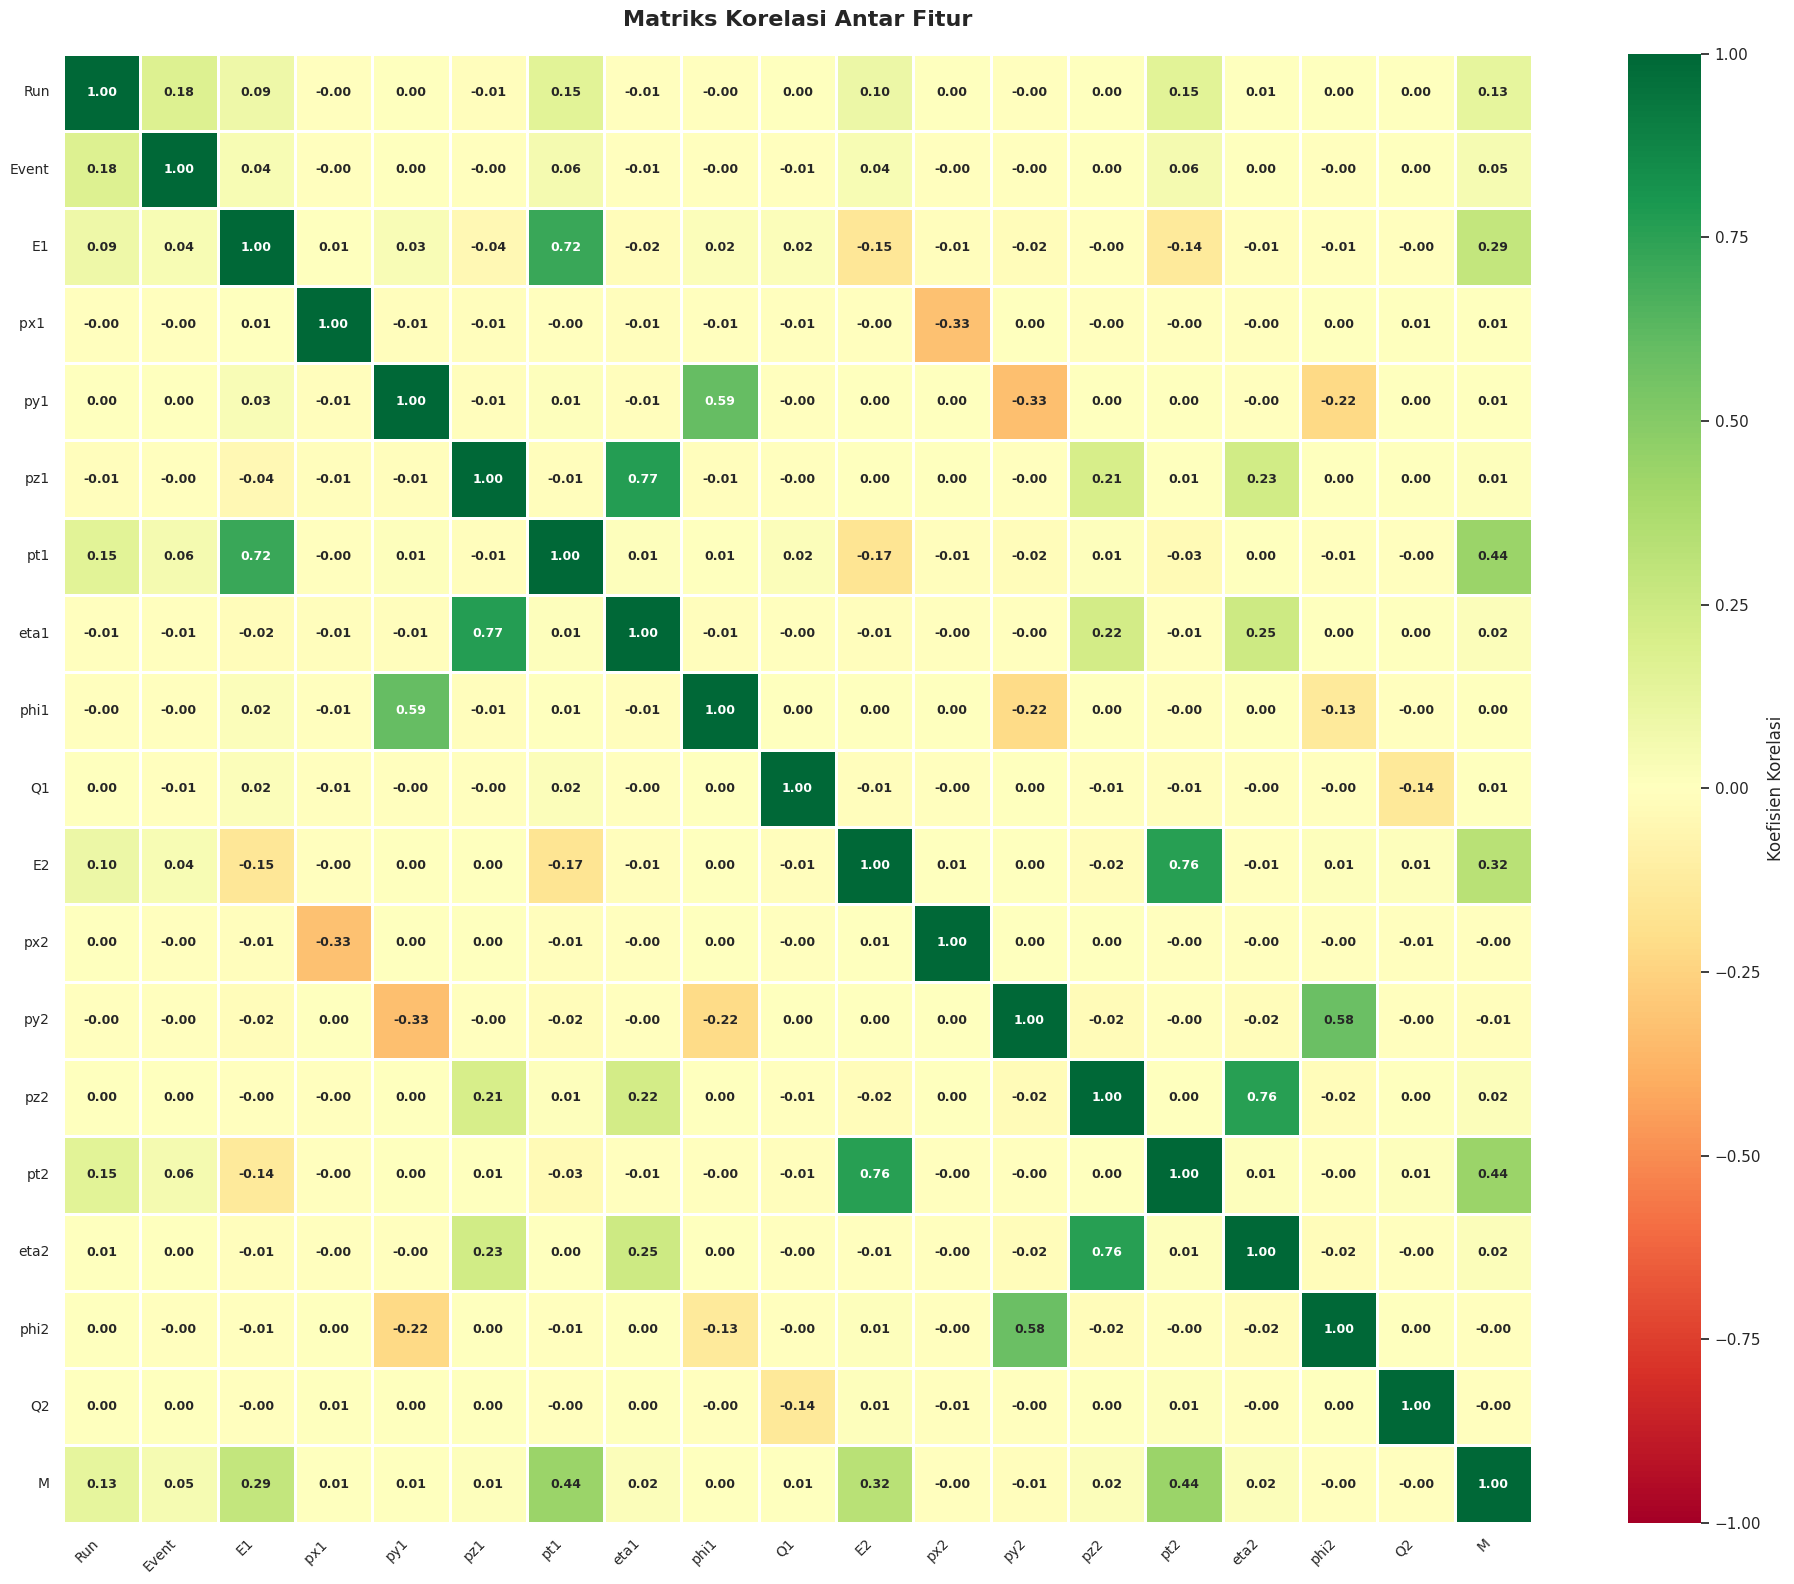


KORELASI TERHADAP TARGET 'M'

Korelasi Positif Tertinggi:
----------------------------------------
  pt2                 :  0.4372
  pt1                 :  0.4371
  E2                  :  0.3247
  E1                  :  0.2852
  Run                 :  0.1295

Korelasi Negatif Tertinggi:
----------------------------------------
  py2                 : -0.0117
  px2                 : -0.0044
  phi2                : -0.0041
  Q2                  : -0.0004


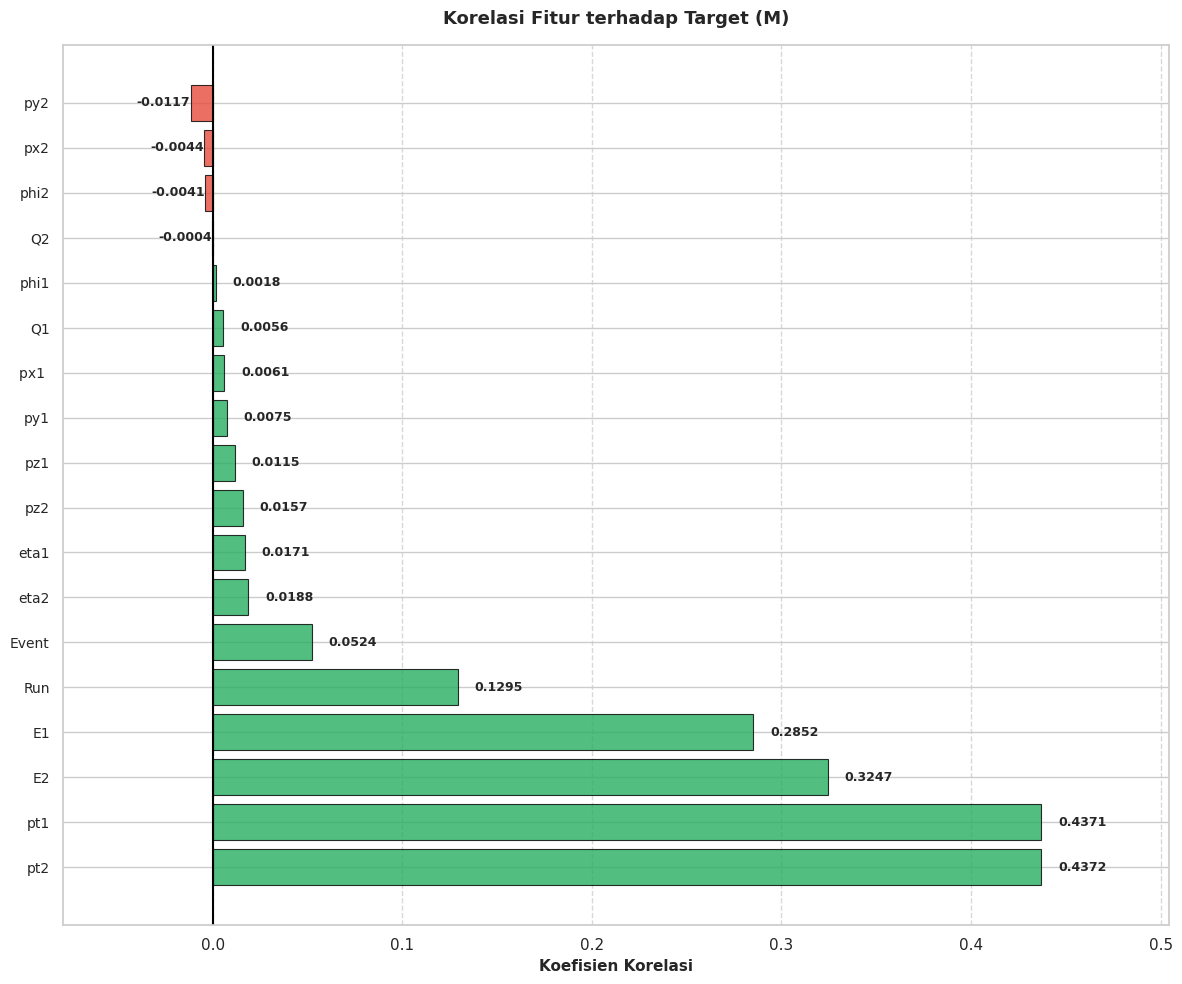

In [24]:
correlation = df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='RdYlGn',
            linewidths=1, linecolor='white', vmin=-1, vmax=1,
            cbar_kws={'label': 'Koefisien Korelasi'},
            square=True, annot_kws={'size': 9, 'weight': 'bold'})

plt.title("Matriks Korelasi Antar Fitur", fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KORELASI TERHADAP TARGET 'M'")
print("="*60)

target_corr = correlation['M'].sort_values(ascending=False)

print("\nKorelasi Positif Tertinggi:")
print("-" * 40)
for feature, corr_value in target_corr.head(6).items():
    if feature != 'M':
        print(f"  {feature:20s}: {corr_value:7.4f}")

negative_corr = target_corr[target_corr < 0].sort_values()
if len(negative_corr) > 0:
    print("\nKorelasi Negatif Tertinggi:")
    print("-" * 40)
    for feature, corr_value in negative_corr.head(5).items():
        print(f"  {feature:20s}: {corr_value:7.4f}")
else:
    print("\nTidak ada korelasi negatif dengan target 'M'")

print("="*60)

fig, ax = plt.subplots(figsize=(12, 10))

target_corr_filtered = target_corr[target_corr.index != 'M']
colors = ['#27AE60' if x > 0 else '#E74C3C' for x in target_corr_filtered.values]

bars = ax.barh(range(len(target_corr_filtered)), target_corr_filtered.values,
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(target_corr_filtered)))
ax.set_yticklabels(target_corr_filtered.index, fontsize=10)
ax.set_xlabel('Koefisien Korelasi', fontsize=11, fontweight='bold')
ax.set_title('Korelasi Fitur terhadap Target (M)', fontsize=13, fontweight='bold', pad=15)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
ax.set_axisbelow(True)

x_min = min(target_corr_filtered.min(), 0)
x_max = max(target_corr_filtered.max(), 0)
margin = (x_max - x_min) * 0.15
ax.set_xlim(x_min - margin, x_max + margin)

for i, (idx, value) in enumerate(target_corr_filtered.items()):
    if value > 0:
        ax.text(value + (x_max * 0.02), i, f'{value:.4f}',
                va='center', ha='left', fontsize=9, fontweight='bold')
    else:
        ax.text(value - (abs(x_min) * 0.02), i, f'{value:.4f}',
                va='center', ha='right', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 4.4 Analisis Outlier (Boxplot)

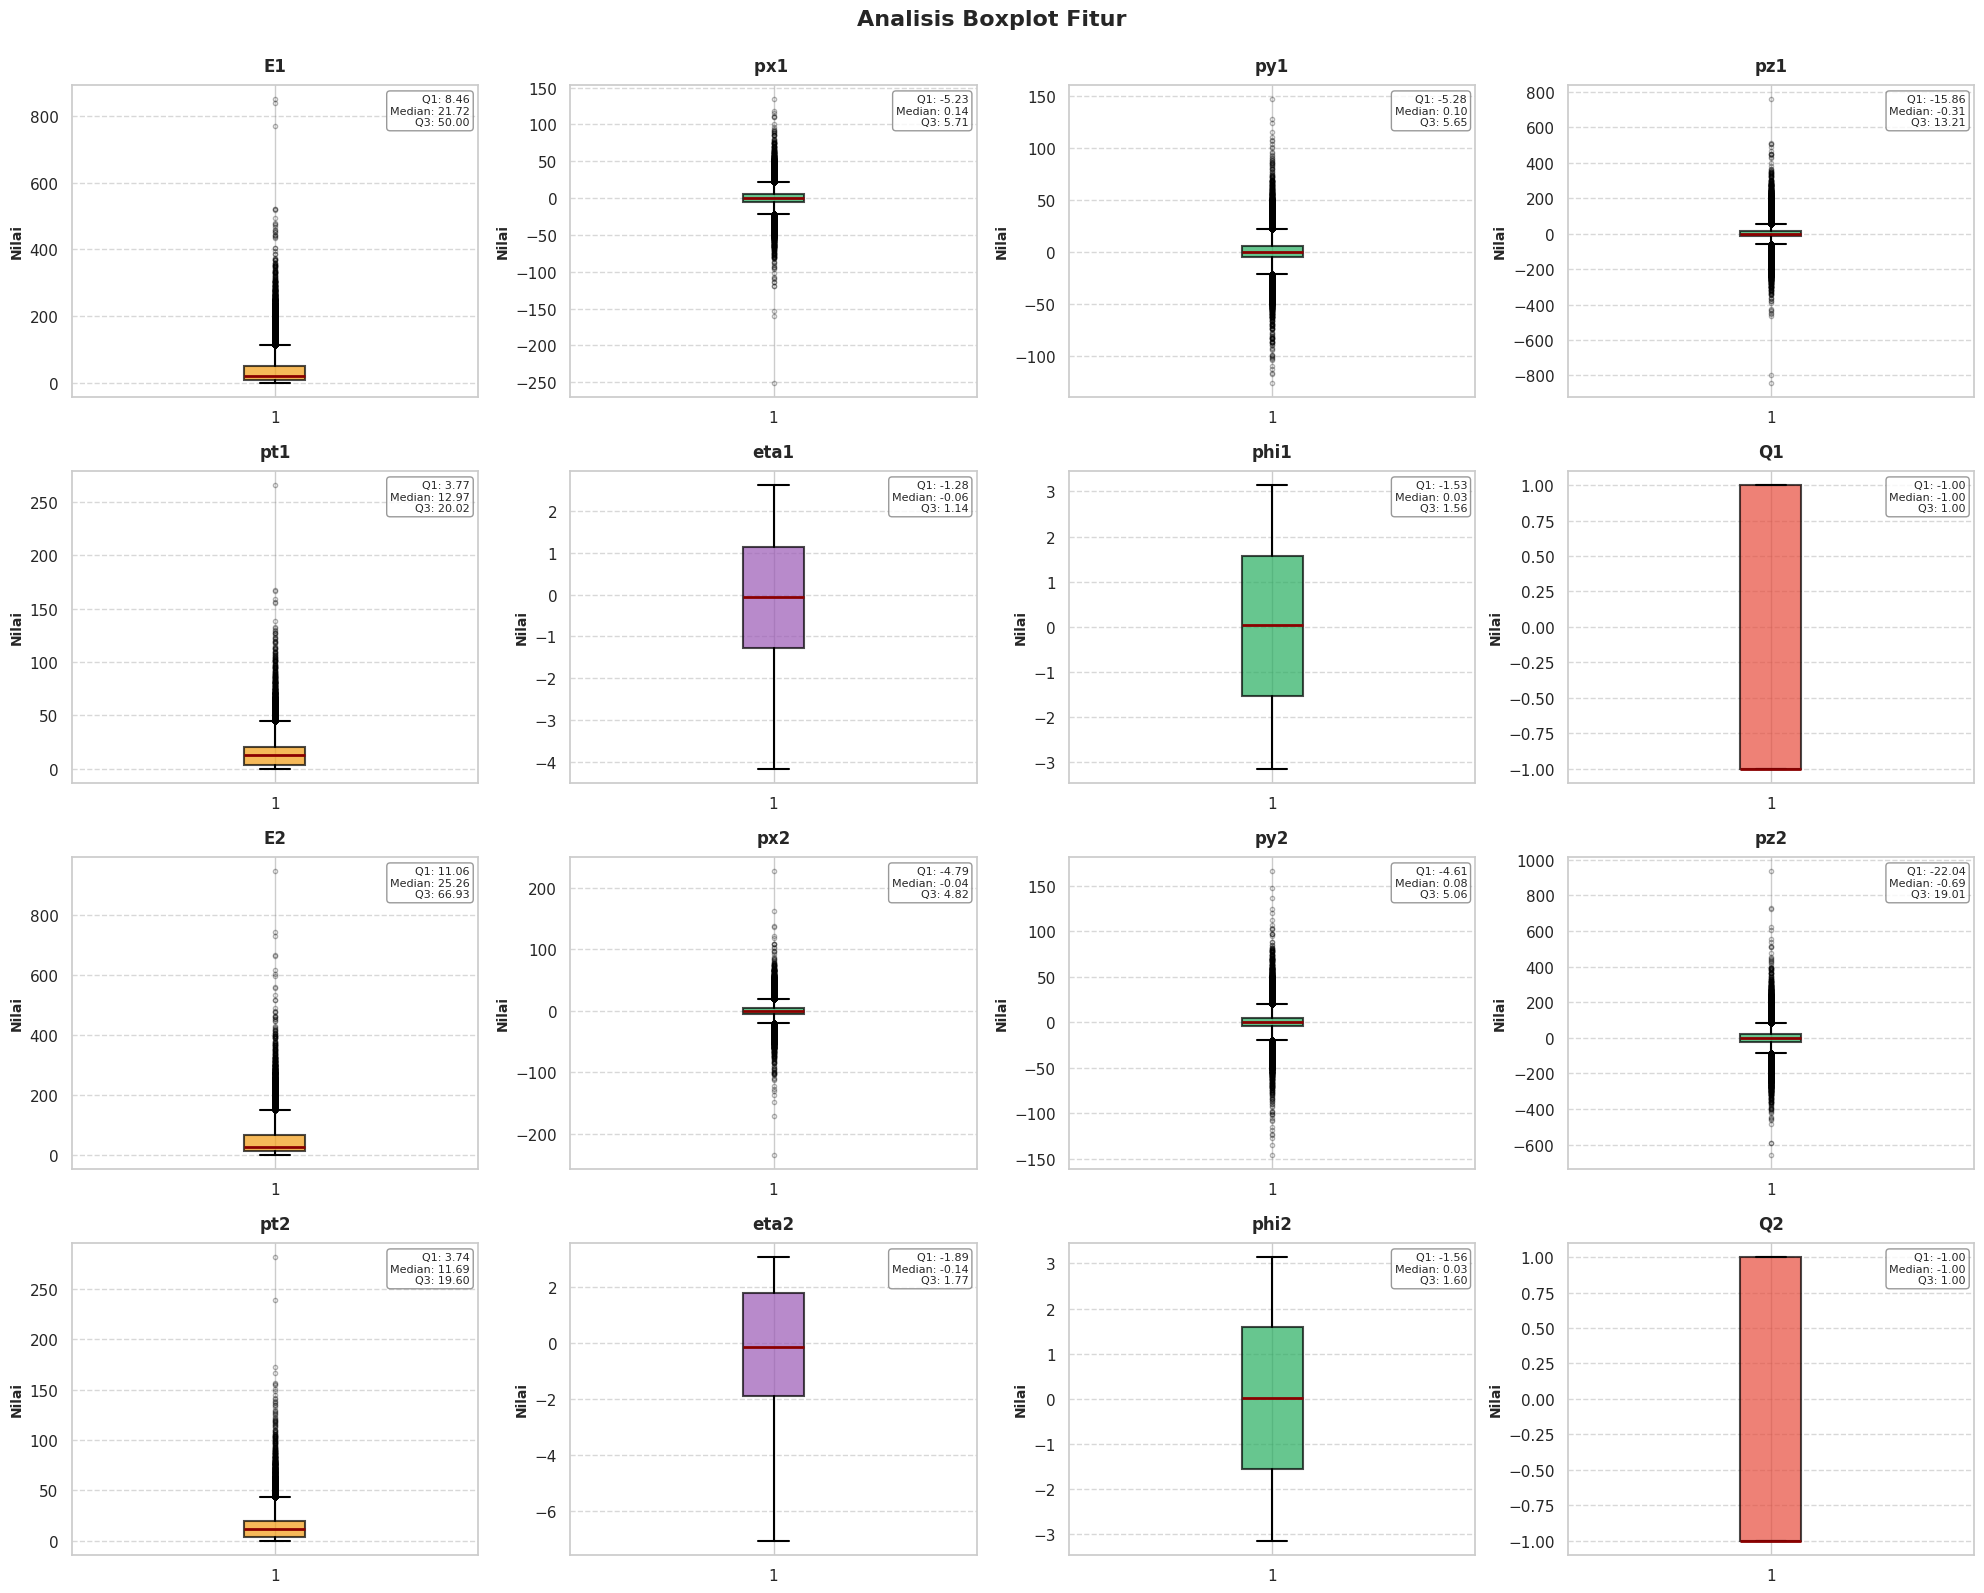


RINGKASAN BOXPLOT
Total Fitur Dicek    : 16
Fitur Ditampilkan    : 16


In [25]:
features_to_check = [col for col in df.columns if col not in ['M', 'Run', 'Event']]

n_cols = 4
n_rows = 4
features_display = features_to_check[:n_cols * n_rows]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(features_display):
    if 'E' in col or 'pt' in col:
        color = '#F39C12'
    elif 'p' in col and 't' not in col:
        color = '#27AE60'
    elif 'phi' in col or 'eta' in col:
        color = '#9B59B6'
    elif 'Q' in col:
        color = '#E74C3C'
    else:
        color = '#3498DB'

    box = axes[i].boxplot(df[col], vert=True, patch_artist=True,
                          boxprops=dict(facecolor=color, alpha=0.7, linewidth=1.5),
                          medianprops=dict(color='darkred', linewidth=2),
                          whiskerprops=dict(linewidth=1.5),
                          capprops=dict(linewidth=1.5),
                          flierprops=dict(marker='o', markersize=3, alpha=0.3))

    axes[i].set_title(f"{col}", fontsize=12, fontweight='bold', pad=10)
    axes[i].set_ylabel("Nilai", fontsize=10, fontweight='bold')
    axes[i].grid(axis='y', linestyle='--', alpha=0.3, color='gray')
    axes[i].set_axisbelow(True)

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    median = df[col].median()

    stats_text = f"Q1: {q1:.2f}\nMedian: {median:.2f}\nQ3: {q3:.2f}"
    axes[i].text(0.98, 0.97, stats_text, transform=axes[i].transAxes,
                fontsize=8, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

for j in range(len(features_display), len(axes)):
    axes[j].axis('off')

plt.suptitle("Analisis Boxplot Fitur", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RINGKASAN BOXPLOT")
print("="*60)
print(f"Total Fitur Dicek    : {len(features_to_check)}")
print(f"Fitur Ditampilkan    : {len(features_display)}")

if len(features_to_check) > n_cols * n_rows:
    remaining = features_to_check[n_cols * n_rows:]
    print(f"Fitur Tidak Tampil   : {len(remaining)}")
    print(f"                       {', '.join(remaining)}")

print("="*60)

## 4.5 Pola Hubungan Fitur vs Target (Scatter Plot)

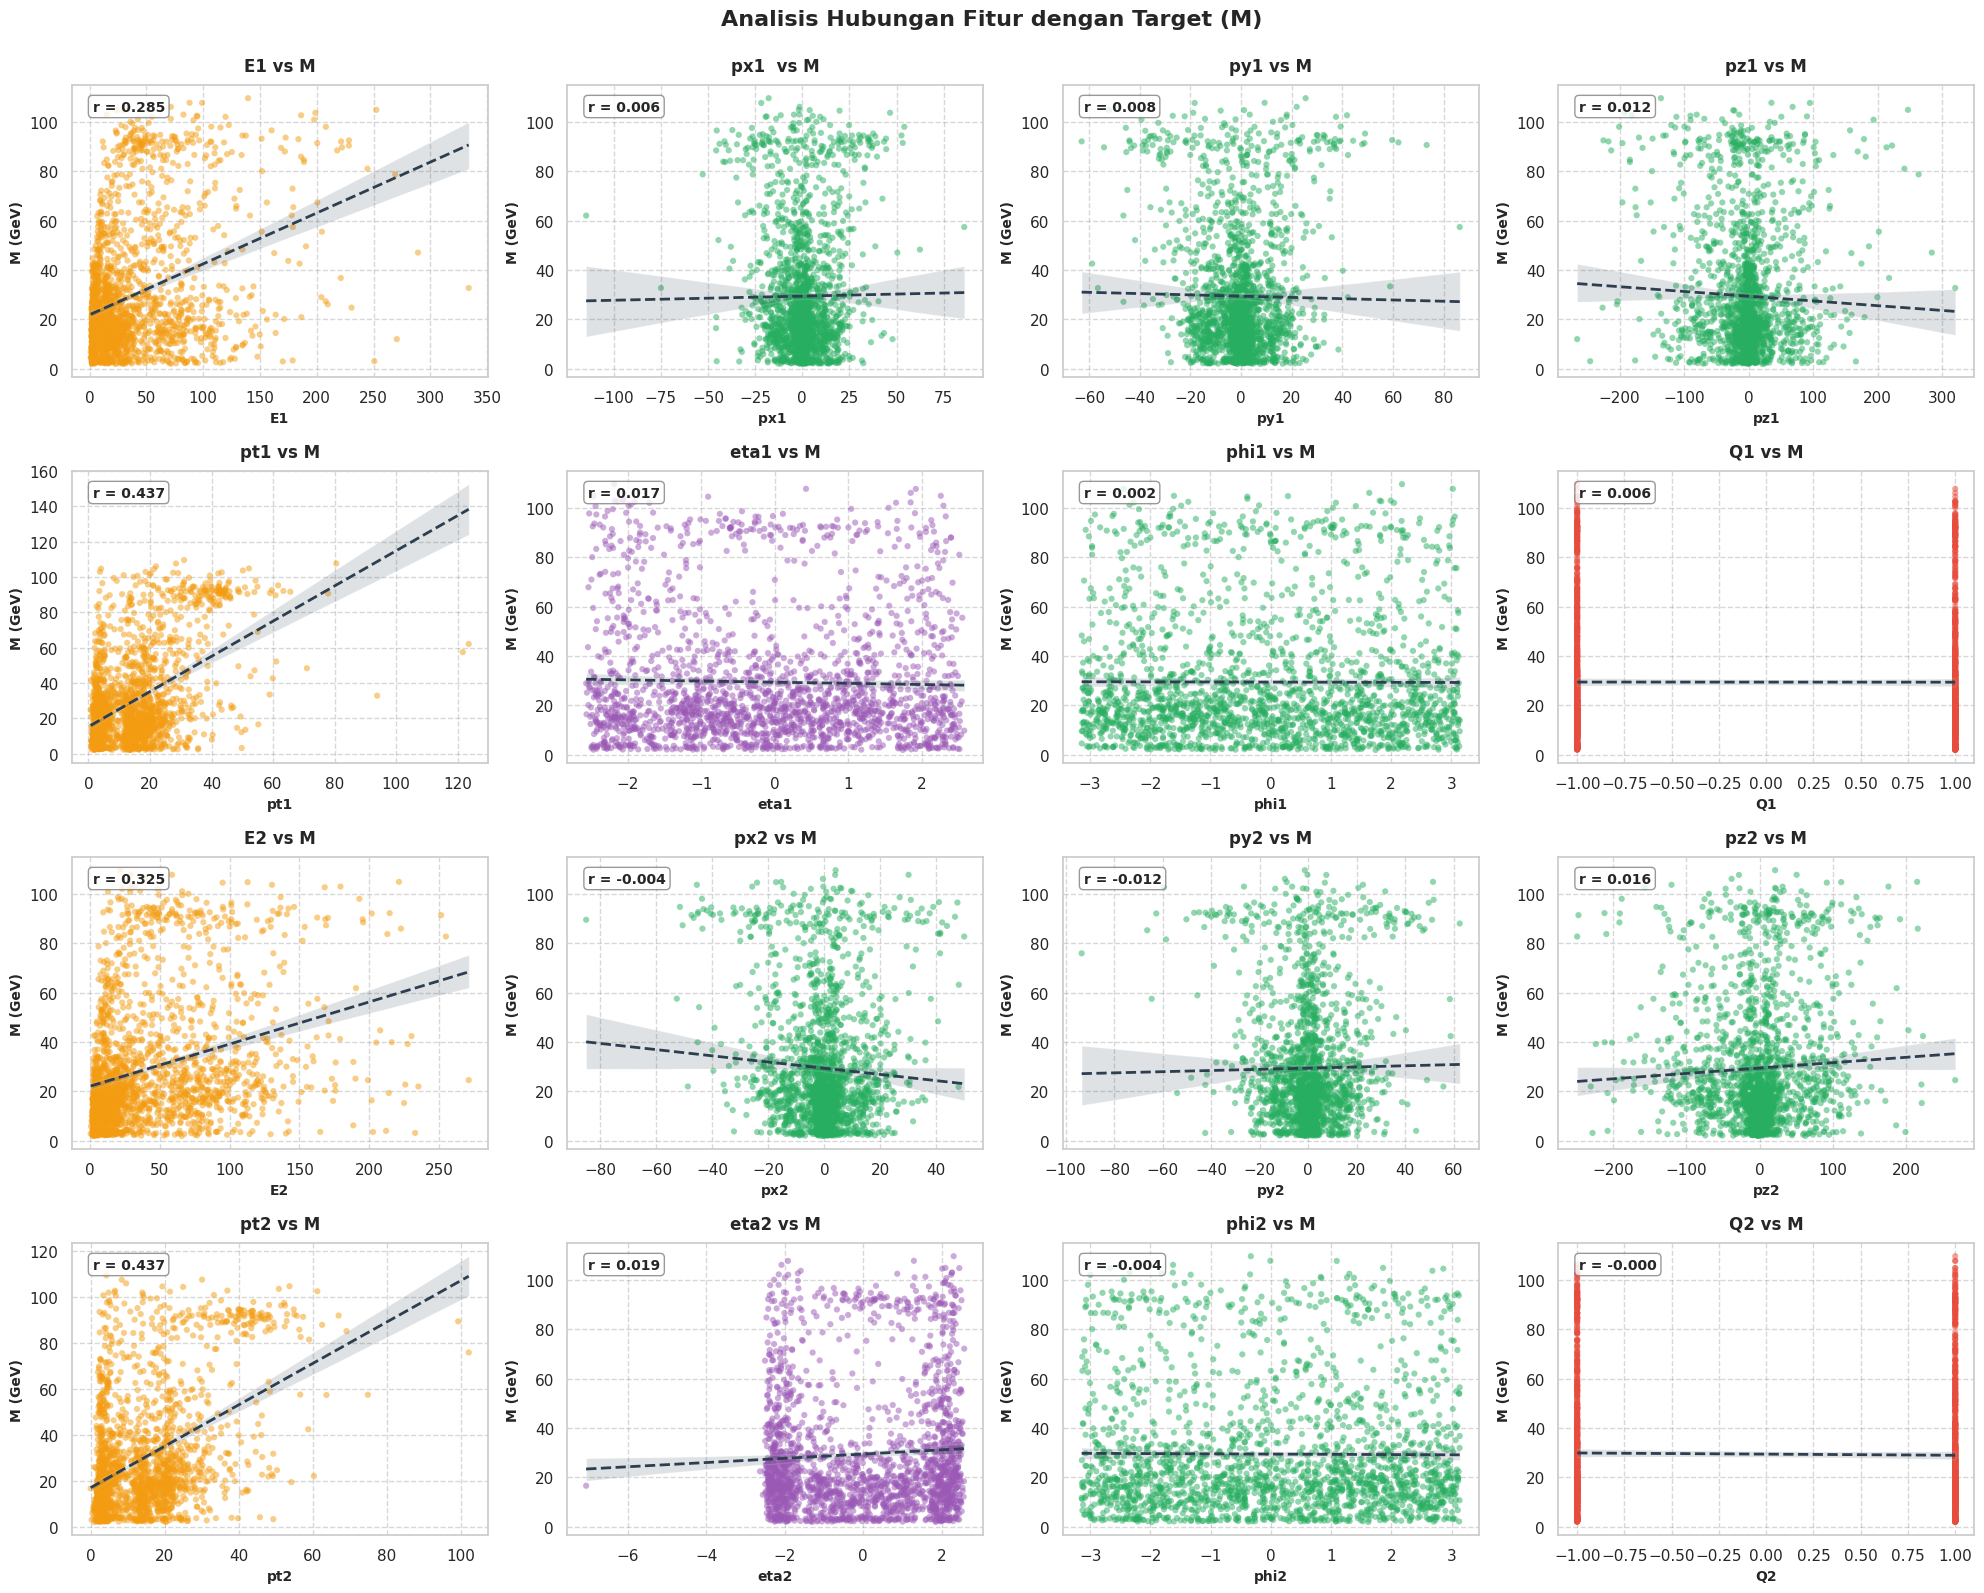


RINGKASAN SCATTER PLOT
Total Fitur          : 16
Fitur Ditampilkan    : 16
Sampel Data          : 2,000 (dari 100,000)


In [26]:
features_to_check = [col for col in df.columns if col not in ['M', 'Run', 'Event']]

df_plot = df.sample(n=2000, random_state=42)

n_cols = 4
n_rows = 4
features_display = features_to_check[:n_cols * n_rows]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(features_display):
    if 'E' in col or 'pt' in col:
        color = '#F39C12'
    elif 'p' in col and 't' not in col:
        color = '#27AE60'
    elif 'phi' in col or 'eta' in col:
        color = '#9B59B6'
    elif 'Q' in col:
        color = '#E74C3C'
    else:
        color = '#3498DB'

    axes[i].scatter(df_plot[col], df_plot['M'], alpha=0.5, s=20,
                   color=color, edgecolors='none')

    sns.regplot(x=df_plot[col], y=df_plot['M'], scatter=False,
               color='#2C3E50', line_kws={'linestyle':'--', 'linewidth':2}, ax=axes[i])

    axes[i].set_title(f"{col} vs M", fontsize=12, fontweight='bold', pad=10)
    axes[i].set_xlabel(col, fontsize=10, fontweight='bold')
    axes[i].set_ylabel("M (GeV)", fontsize=10, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.3, color='gray')
    axes[i].set_axisbelow(True)

    corr_value = df[col].corr(df['M'])
    corr_text = f"r = {corr_value:.3f}"
    axes[i].text(0.05, 0.95, corr_text, transform=axes[i].transAxes,
                fontsize=10, verticalalignment='top', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

for j in range(len(features_display), len(axes)):
    axes[j].axis('off')

plt.suptitle("Analisis Hubungan Fitur dengan Target (M)", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RINGKASAN SCATTER PLOT")
print("="*60)
print(f"Total Fitur          : {len(features_to_check)}")
print(f"Fitur Ditampilkan    : {len(features_display)}")
print(f"Sampel Data          : 2,000 (dari {len(df):,})")

if len(features_to_check) > n_cols * n_rows:
    remaining = features_to_check[n_cols * n_rows:]
    print(f"Fitur Tidak Tampil   : {len(remaining)}")
    print(f"                       {', '.join(remaining)}")

print("="*60)

#Preprocessing

## 5.1 Data Cleaning & Sampling

In [27]:
print("\n" + "="*60)
print("PROSES PEMBERSIHAN DATA")
print("="*60)

print(f"\n1. Data Awal (Raw)")
print(f"   Jumlah Baris       : {df.shape[0]:,}")
print(f"   Jumlah Kolom       : {df.shape[1]}")

cols_to_drop = ['Run', 'Event']
existing_cols = [c for c in cols_to_drop if c in df.columns]
df_clean = df.drop(columns=existing_cols, errors='ignore')

print(f"\n2. Setelah Drop Kolom ID")
print(f"   Kolom Dihapus      : {', '.join(existing_cols) if existing_cols else 'Tidak ada'}")
print(f"   Jumlah Kolom       : {df_clean.shape[1]}")

duplicates_count = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()

print(f"\n3. Setelah Hapus Duplikat")
print(f"   Duplikat Dihapus   : {duplicates_count:,}")
print(f"   Jumlah Baris       : {df_clean.shape[0]:,}")

missing_count = df_clean.isnull().sum().sum()
df_clean = df_clean.dropna()

print(f"\n4. Setelah Hapus Missing Values")
print(f"   Missing Dihapus    : {missing_count:,}")
print(f"   Jumlah Baris       : {df_clean.shape[0]:,}")

print(f"\n5. Data Bersih (Full)")
print(f"   Jumlah Baris       : {df_clean.shape[0]:,}")
print(f"   Jumlah Kolom       : {df_clean.shape[1]}")
print(f"   Data Hilang        : {df.shape[0] - df_clean.shape[0]:,} ({((df.shape[0] - df_clean.shape[0]) / df.shape[0] * 100):.2f}%)")

df_final = df_clean.sample(n=2000, random_state=42)

print(f"\n6. Sampling untuk Model")
print(f"   Sampel Diambil     : 2,000")
print(f"   Jumlah Fitur       : {df_final.shape[1] - 1} (tanpa target 'M')")
print(f"   Shape Final        : {df_final.shape}")

print("\n" + "="*60)
print("RINGKASAN PEMBERSIHAN")
print("="*60)
print(f"Data Awal             : {df.shape[0]:,} baris")
print(f"Data Bersih (Full)    : {df_clean.shape[0]:,} baris")
print(f"Data Final (Model)    : {df_final.shape[0]:,} baris")
print(f"Persentase Digunakan  : {(df_final.shape[0] / df.shape[0] * 100):.2f}%")
print("="*60)


PROSES PEMBERSIHAN DATA

1. Data Awal (Raw)
   Jumlah Baris       : 100,000
   Jumlah Kolom       : 19

2. Setelah Drop Kolom ID
   Kolom Dihapus      : Run, Event
   Jumlah Kolom       : 17

3. Setelah Hapus Duplikat
   Duplikat Dihapus   : 23
   Jumlah Baris       : 99,977

4. Setelah Hapus Missing Values
   Missing Dihapus    : 85
   Jumlah Baris       : 99,892

5. Data Bersih (Full)
   Jumlah Baris       : 99,892
   Jumlah Kolom       : 17
   Data Hilang        : 108 (0.11%)

6. Sampling untuk Model
   Sampel Diambil     : 2,000
   Jumlah Fitur       : 16 (tanpa target 'M')
   Shape Final        : (2000, 17)

RINGKASAN PEMBERSIHAN
Data Awal             : 100,000 baris
Data Bersih (Full)    : 99,892 baris
Data Final (Model)    : 2,000 baris
Persentase Digunakan  : 2.00%


## 5.2 Pemisahan Fitur dan Target

In [28]:
print("\n" + "="*60)
print("PEMISAHAN FITUR DAN TARGET")
print("="*60)

X = df_final.drop('M', axis=1)
y = df_final['M']

print(f"\nFitur (X):")
print(f"   Shape              : {X.shape}")
print(f"   Jumlah Fitur       : {X.shape[1]}")
print(f"   Jumlah Sampel      : {X.shape[0]:,}")

print(f"\nTarget (y):")
print(f"   Shape              : {y.shape}")
print(f"   Nama Target        : 'M' (Invariant Mass)")
print(f"   Jumlah Sampel      : {y.shape[0]:,}")

print(f"\nDaftar Fitur ({X.shape[1]} kolom):")
print("-" * 40)
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

print("\n" + "="*60)
print("KETERANGAN")
print("="*60)
print("X : Variabel independen (fitur input untuk model)")
print("y : Variabel dependen (target yang akan diprediksi)")
print("="*60)


PEMISAHAN FITUR DAN TARGET

Fitur (X):
   Shape              : (2000, 16)
   Jumlah Fitur       : 16
   Jumlah Sampel      : 2,000

Target (y):
   Shape              : (2000,)
   Nama Target        : 'M' (Invariant Mass)
   Jumlah Sampel      : 2,000

Daftar Fitur (16 kolom):
----------------------------------------
    1. E1
    2. px1 
    3. py1
    4. pz1
    5. pt1
    6. eta1
    7. phi1
    8. Q1
    9. E2
   10. px2
   11. py2
   12. pz2
   13. pt2
   14. eta2
   15. phi2
   16. Q2

KETERANGAN
X : Variabel independen (fitur input untuk model)
y : Variabel dependen (target yang akan diprediksi)


## 5.3 Train-Test Split

In [29]:
print("\n" + "="*60)
print("PEMBAGIAN DATA TRAINING DAN TESTING")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTotal Data            : {len(X):,}")
print(f"Rasio Split           : 80% Training / 20% Testing")

print(f"\nData Training:")
print(f"   X_train shape      : {X_train.shape}")
print(f"   y_train shape      : {y_train.shape}")
print(f"   Jumlah Sampel      : {X_train.shape[0]:,} ({(X_train.shape[0]/len(X)*100):.1f}%)")

print(f"\nData Testing:")
print(f"   X_test shape       : {X_test.shape}")
print(f"   y_test shape       : {y_test.shape}")
print(f"   Jumlah Sampel      : {X_test.shape[0]:,} ({(X_test.shape[0]/len(X)*100):.1f}%)")

print(f"\nStatistik Target (y):")
print("-" * 40)
print(f"Training Set:")
print(f"   Mean               : {y_train.mean():.4f}")
print(f"   Std                : {y_train.std():.4f}")
print(f"   Min                : {y_train.min():.4f}")
print(f"   Max                : {y_train.max():.4f}")

print(f"\nTesting Set:")
print(f"   Mean               : {y_test.mean():.4f}")
print(f"   Std                : {y_test.std():.4f}")
print(f"   Min                : {y_test.min():.4f}")
print(f"   Max                : {y_test.max():.4f}")

print("\n" + "="*60)
print("KETERANGAN")
print("="*60)
print("Training Set : Digunakan untuk melatih model")
print("Testing Set  : Digunakan untuk evaluasi performa model")
print("Random State : 42 (untuk reproducibility)")
print("="*60)


PEMBAGIAN DATA TRAINING DAN TESTING

Total Data            : 2,000
Rasio Split           : 80% Training / 20% Testing

Data Training:
   X_train shape      : (1600, 16)
   y_train shape      : (1600,)
   Jumlah Sampel      : 1,600 (80.0%)

Data Testing:
   X_test shape       : (400, 16)
   y_test shape       : (400,)
   Jumlah Sampel      : 400 (20.0%)

Statistik Target (y):
----------------------------------------
Training Set:
   Mean               : 30.4870
   Std                : 25.5246
   Min                : 2.0452
   Max                : 109.0110

Testing Set:
   Mean               : 29.7571
   Std                : 24.8984
   Min                : 2.2246
   Max                : 105.5950

KETERANGAN
Training Set : Digunakan untuk melatih model
Testing Set  : Digunakan untuk evaluasi performa model
Random State : 42 (untuk reproducibility)


## 5.4 Feature Scaling

In [30]:
print("\n" + "="*60)
print("STANDARDISASI DATA (SCALING)")
print("="*60)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"\nMetode Scaling        : StandardScaler (Z-score normalization)")
print(f"Formula               : z = (x - mean) / std")

print(f"\nData Training:")
print(f"   Shape              : {X_train_scaled.shape}")
print(f"   Mean (semua fitur) : {X_train_scaled.mean().mean():.6f}")
print(f"   Std (semua fitur)  : {X_train_scaled.std().mean():.6f}")

print(f"\nData Testing:")
print(f"   Shape              : {X_test_scaled.shape}")
print(f"   Mean (semua fitur) : {X_test_scaled.mean().mean():.6f}")
print(f"   Std (semua fitur)  : {X_test_scaled.std().mean():.6f}")

print("\n" + "="*60)
print("PREVIEW DATA SETELAH SCALING (3 Baris Pertama)")
print("="*60)
display(X_train_scaled.head(3))

print("\n" + "="*60)
print("PERBANDINGAN SEBELUM DAN SESUDAH SCALING")
print("="*60)

comparison = pd.DataFrame({
    'Fitur': X.columns[:5],
    'Mean (Sebelum)': X_train.iloc[:, :5].mean().values,
    'Std (Sebelum)': X_train.iloc[:, :5].std().values,
    'Mean (Sesudah)': X_train_scaled.iloc[:, :5].mean().values,
    'Std (Sesudah)': X_train_scaled.iloc[:, :5].std().values
})

display(comparison.round(4))

print("\n" + "="*60)
print("KETERANGAN")
print("="*60)
print("StandardScaler mentransformasi fitur agar memiliki:")
print("  - Mean (rata-rata) = 0")
print("  - Standard Deviation (simpangan baku) = 1")
print("\nManfaat:")
print("  - Menyamakan skala semua fitur")
print("  - Mempercepat konvergensi model")
print("  - Meningkatkan performa algoritma (SVR, Neural Network)")
print("="*60)


STANDARDISASI DATA (SCALING)

Metode Scaling        : StandardScaler (Z-score normalization)
Formula               : z = (x - mean) / std

Data Training:
   Shape              : (1600, 16)
   Mean (semua fitur) : 0.000000
   Std (semua fitur)  : 1.000313

Data Testing:
   Shape              : (400, 16)
   Mean (semua fitur) : -0.024088
   Std (semua fitur)  : 0.963888

PREVIEW DATA SETELAH SCALING (3 Baris Pertama)


,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2
0,0.635323,4.702741,-1.273596,-0.120202,3.923809,-0.038008,-0.195884,0.998751,-0.345960,-0.999083,-0.096769,0.428226,-0.012654,0.799518,-1.634904,-0.981423
1,-0.268046,-0.846909,-0.427967,0.436864,-0.192021,0.978034,-1.527122,-1.001251,-0.914102,0.008811,-0.184153,0.026009,-0.903574,0.155395,-0.910671,1.018929
2,-0.315717,-1.035860,0.872469,-0.200917,0.295651,-0.407229,1.281921,0.998751,-0.650733,0.381825,0.128146,-0.213261,-0.728515,-1.002618,0.183414,-0.981423



PERBANDINGAN SEBELUM DAN SESUDAH SCALING


,Fitur,Mean (Sebelum),Std (Sebelum),Mean (Sesudah),Std (Sesudah)
0,E1,37.5579,46.0839,0.0,1.0003
1,px1,0.6630,13.4177,0.0,1.0003
2,py1,0.4366,14.3822,-0.0,1.0003
3,pz1,-2.3805,56.0537,-0.0,1.0003
4,pt1,14.6515,13.1420,-0.0,1.0003



KETERANGAN
StandardScaler mentransformasi fitur agar memiliki:
  - Mean (rata-rata) = 0
  - Standard Deviation (simpangan baku) = 1

Manfaat:
  - Menyamakan skala semua fitur
  - Mempercepat konvergensi model
  - Meningkatkan performa algoritma (SVR, Neural Network)


#Modelling

## 6.1 Inisialisasi Model

In [31]:
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Reg (Deg 2)": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "SVR (RBF Kernel)": SVR(kernel='rbf', C=100, gamma='scale'),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
}

print("Semua model berhasil diinisialisasi.")

Semua model berhasil diinisialisasi.


## 6.2 Training Model

In [32]:
print("\n" + "="*60)
print("TRAINING MODEL")
print("="*60)

trained_models = {}

print(f"\nJumlah Model          : {len(models)}")
print(f"Data Training         : {X_train_scaled.shape[0]:,} sampel")
print(f"Jumlah Fitur          : {X_train_scaled.shape[1]}")

print("\nMemulai proses training...\n")

for i, (name, model) in enumerate(models.items(), 1):
    print(f"[{i}/{len(models)}] Training {name}...", end=" ")

    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

    print("Selesai")

print("\n" + "="*60)
print("RINGKASAN TRAINING")
print("="*60)
print(f"Total Model Terlatih  : {len(trained_models)}")
print(f"Model yang Tersedia   :")
for i, name in enumerate(trained_models.keys(), 1):
    print(f"  {i}. {name}")
print("="*60)

print("\n" + "="*60)
print("TRAINING SCORE (Performa di Data Training)")
print("="*60)

for name, model in trained_models.items():
    y_train_pred = model.predict(X_train_scaled)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    print(f"\n=== {name} ===")
    print(f"MAE (Train):  {mae_train:.4f}")
    print(f"RMSE (Train): {rmse_train:.4f}")
    print(f"R² (Train):   {r2_train:.4f}")


TRAINING MODEL

Jumlah Model          : 5
Data Training         : 1,600 sampel
Jumlah Fitur          : 16

Memulai proses training...

[1/5] Training Linear Regression... Selesai
[2/5] Training Polynomial Reg (Deg 2)... Selesai
[3/5] Training SVR (RBF Kernel)... Selesai
[4/5] Training Random Forest... Selesai
[5/5] Training XGBoost... Selesai

RINGKASAN TRAINING
Total Model Terlatih  : 5
Model yang Tersedia   :
  1. Linear Regression
  2. Polynomial Reg (Deg 2)
  3. SVR (RBF Kernel)
  4. Random Forest
  5. XGBoost

TRAINING SCORE (Performa di Data Training)

=== Linear Regression ===
MAE (Train):  14.0628
RMSE (Train): 19.4649
R² (Train):   0.4181

=== Polynomial Reg (Deg 2) ===
MAE (Train):  2.9738
RMSE (Train): 3.7346
R² (Train):   0.9786

=== SVR (RBF Kernel) ===
MAE (Train):  0.7784
RMSE (Train): 1.6576
R² (Train):   0.9958

=== Random Forest ===
MAE (Train):  3.3399
RMSE (Train): 4.7937
R² (Train):   0.9647

=== XGBoost ===
MAE (Train):  0.4051
RMSE (Train): 0.5696
R² (Train):   

## 6.3 Cross-Validation


VALIDASI MODEL DENGAN CROSS-VALIDATION (5-Fold)

Metode               : K-Fold Cross-Validation
Jumlah Fold          : 5
Shuffle              : True
Random State         : 42
Scoring Metric       : RMSE (Root Mean Squared Error)

Memulai proses validasi...

[1/5] Validasi Linear Regression... ✓ Selesai
[2/5] Validasi Polynomial Reg (Deg 2)... ✓ Selesai
[3/5] Validasi SVR (RBF Kernel)... ✓ Selesai
[4/5] Validasi Random Forest... ✓ Selesai
[5/5] Validasi XGBoost... ✓ Selesai

=== HASIL CROSS-VALIDATION (5-Fold) ===


,Model,RMSE (Mean),RMSE (Std)
1,Polynomial Reg (Deg 2),5.3658,1.0129
2,SVR (RBF Kernel),6.3719,0.6734
4,XGBoost,10.1152,0.6034
3,Random Forest,13.1125,0.5025
0,Linear Regression,20.0768,0.6390


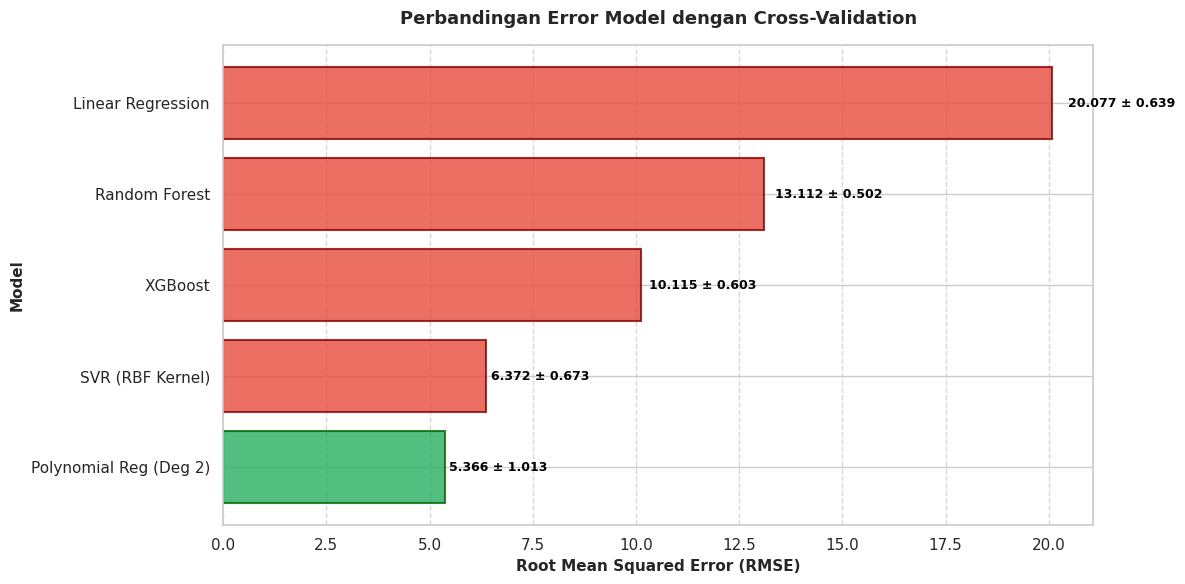


MODEL TERBAIK (Cross-Validation)

Model: Polynomial Reg (Deg 2)
RMSE (Mean): 5.3658
RMSE (Std): 1.0129


In [33]:
print("\n" + "="*60)
print("VALIDASI MODEL DENGAN CROSS-VALIDATION (5-Fold)")
print("="*60)

results_cv = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"\nMetode               : K-Fold Cross-Validation")
print(f"Jumlah Fold          : 5")
print(f"Shuffle              : True")
print(f"Random State         : 42")
print(f"Scoring Metric       : RMSE (Root Mean Squared Error)")

print("\nMemulai proses validasi...\n")

for i, (name, model) in enumerate(models.items(), 1):
    print(f"[{i}/{len(models)}] Validasi {name}...", end=" ")

    from sklearn.base import clone
    model_clone = clone(model)

    cv_scores = cross_val_score(model_clone, X_train_scaled, y_train,
                               cv=kfold, scoring='neg_root_mean_squared_error')
    rmse_scores = -cv_scores

    results_cv.append({
        "Model": name,
        "RMSE (Mean)": rmse_scores.mean(),
        "RMSE (Std)": rmse_scores.std()
    })

    print("✓ Selesai")

df_cv = pd.DataFrame(results_cv).sort_values(by="RMSE (Mean)", ascending=True)

print("\n=== HASIL CROSS-VALIDATION (5-Fold) ===")

styled_table = df_cv.style.format({
    "RMSE (Mean)": "{:.4f}",
    "RMSE (Std)": "{:.4f}"
})

display(styled_table)

plt.figure(figsize=(12, 6))

error_color = '#E74C3C'

bars = plt.barh(
    range(len(df_cv)),
    df_cv["RMSE (Mean)"],
    color=error_color,
    alpha=0.8,
    edgecolor='darkred',
    linewidth=1.5
)

bars[0].set_color('#27AE60')
bars[0].set_edgecolor('darkgreen')

plt.yticks(range(len(df_cv)), df_cv["Model"])

for i, (idx, row) in enumerate(df_cv.iterrows()):
    v = row["RMSE (Mean)"]
    std = row["RMSE (Std)"]
    plt.text(
        v + (v * 0.02),
        i,
        f"{v:.3f} ± {std:.3f}",
        color='black',
        va='center',
        fontweight='bold',
        fontsize=9
    )

plt.title("Perbandingan Error Model dengan Cross-Validation", fontsize=13, fontweight='bold', pad=15)
plt.xlabel("Root Mean Squared Error (RMSE)", fontsize=11, fontweight='bold')
plt.ylabel("Model", fontsize=11, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("MODEL TERBAIK (Cross-Validation)")
print("="*60)

best_model = df_cv.iloc[0]
print(f"\nModel: {best_model['Model']}")
print(f"RMSE (Mean): {best_model['RMSE (Mean)']:.4f}")
print(f"RMSE (Std): {best_model['RMSE (Std)']:.4f}")
print("="*60)

#Evaluasi

## 7.1 Hitung Metrik Evaluasi

In [34]:
print("\n" + "="*60)
print("EVALUASI PERFORMA MODEL PADA DATA TESTING")
print("="*60)

final_results = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    final_results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2
    })

df_final = pd.DataFrame(final_results).sort_values(by="RMSE", ascending=True)

print(f"\nJumlah Model Dievaluasi: {len(df_final)}")
print(f"Data Testing: {len(y_test)} sampel")

print("\n" + "="*60)
print("HASIL EVALUASI (Diurutkan berdasarkan RMSE)")
print("="*60)

styled_df = df_final.style.format({
    "MAE": "{:.4f}",
    "RMSE": "{:.4f}",
    "R2 Score": "{:.4f}"
})

display(styled_df)

print("\n" + "="*60)
print("INTERPRETASI METRIK")
print("="*60)
print("MAE (Mean Absolute Error):")
print("  - Rata-rata selisih absolut antara prediksi dan aktual")
print("  - Semakin rendah semakin baik")
print("  - Satuan: GeV (sama dengan target)")

print("\nRMSE (Root Mean Squared Error):")
print("  - Akar dari rata-rata kuadrat error")
print("  - Lebih sensitif terhadap outlier dibanding MAE")
print("  - Semakin rendah semakin baik")
print("  - Satuan: GeV (sama dengan target)")

print("\nR² Score (Coefficient of Determination):")
print("  - Proporsi variansi target yang bisa dijelaskan model")
print("  - Range: 0 (buruk) sampai 1 (sempurna)")
print("  - Semakin tinggi semakin baik")

print("\n" + "="*60)
print("MODEL TERBAIK")
print("="*60)

best_model = df_final.iloc[0]
print(f"\nModel: {best_model['Model']}")
print(f"  MAE      : {best_model['MAE']:.4f} GeV")
print(f"  RMSE     : {best_model['RMSE']:.4f} GeV")
print(f"  R² Score : {best_model['R2 Score']:.4f}")

if best_model['R2 Score'] >= 0.9:
    interpretation = "Excellent (>0.9)"
elif best_model['R2 Score'] >= 0.8:
    interpretation = "Good (0.8-0.9)"
elif best_model['R2 Score'] >= 0.7:
    interpretation = "Fair (0.7-0.8)"
else:
    interpretation = "Needs Improvement (<0.7)"

print(f"\nKualitas Prediksi: {interpretation}")
print("="*60)


EVALUASI PERFORMA MODEL PADA DATA TESTING

Jumlah Model Dievaluasi: 5
Data Testing: 400 sampel

HASIL EVALUASI (Diurutkan berdasarkan RMSE)


,Model,MAE,RMSE,R2 Score
1,Polynomial Reg (Deg 2),3.5400,5.6214,0.9489
2,SVR (RBF Kernel),3.1105,5.7009,0.9474
4,XGBoost,6.5630,9.6732,0.8487
3,Random Forest,9.3055,13.1733,0.7194
0,Linear Regression,14.1999,19.4899,0.3857



INTERPRETASI METRIK
MAE (Mean Absolute Error):
  - Rata-rata selisih absolut antara prediksi dan aktual
  - Semakin rendah semakin baik
  - Satuan: GeV (sama dengan target)

RMSE (Root Mean Squared Error):
  - Akar dari rata-rata kuadrat error
  - Lebih sensitif terhadap outlier dibanding MAE
  - Semakin rendah semakin baik
  - Satuan: GeV (sama dengan target)

R² Score (Coefficient of Determination):
  - Proporsi variansi target yang bisa dijelaskan model
  - Range: 0 (buruk) sampai 1 (sempurna)
  - Semakin tinggi semakin baik

MODEL TERBAIK

Model: Polynomial Reg (Deg 2)
  MAE      : 3.5400 GeV
  RMSE     : 5.6214 GeV
  R² Score : 0.9489

Kualitas Prediksi: Excellent (>0.9)


## 7.2 Visualisasi Perbandingan Model


=== PERINGKAT PERFORMA MODEL (DATA UJI) ===


,Model,MAE,RMSE,R2 Score
1,Polynomial Reg (Deg 2),3.5400,5.6214,0.9489
2,SVR (RBF Kernel),3.1105,5.7009,0.9474
4,XGBoost,6.5630,9.6732,0.8487
3,Random Forest,9.3055,13.1733,0.7194
0,Linear Regression,14.1999,19.4899,0.3857


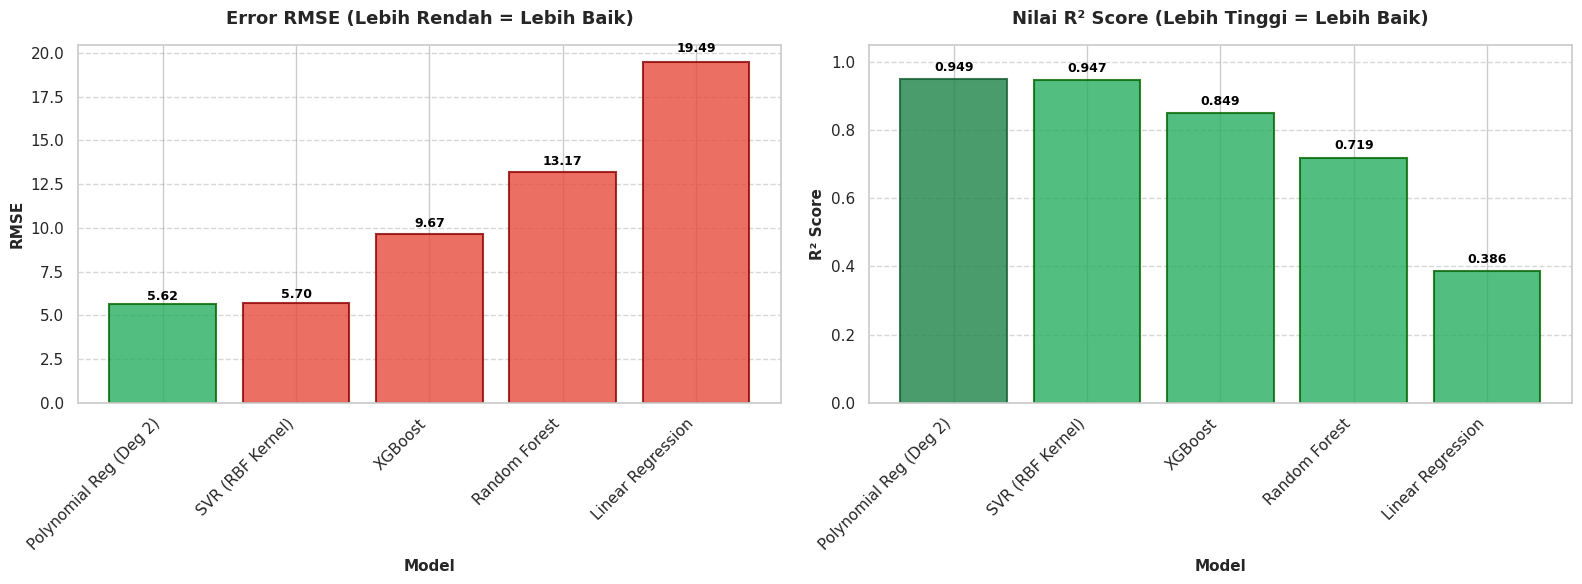


MODEL TERBAIK BERDASARKAN METRIK

RMSE Terendah:
   Model: Polynomial Reg (Deg 2)
   RMSE: 5.6214
   MAE: 3.5400
   R² Score: 0.9489

R² Score Tertinggi:
   Model: Polynomial Reg (Deg 2)
   RMSE: 5.6214
   MAE: 3.5400
   R² Score: 0.9489

MODEL TERBAIK KESELURUHAN: Polynomial Reg (Deg 2)


In [35]:
print("\n=== PERINGKAT PERFORMA MODEL (DATA UJI) ===")

required_cols = ["Model", "MAE", "RMSE", "R2 Score"]
if not all(col in df_final.columns for col in required_cols):
    print("Error: df_final tidak memiliki kolom yang diperlukan")
else:
    styled_final = df_final.style.format({
        "MAE": "{:.4f}",
        "RMSE": "{:.4f}",
        "R2 Score": "{:.4f}"
    })

    display(styled_final)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    error_color = '#E74C3C'
    accuracy_color = '#27AE60'

    df_sorted_rmse = df_final.sort_values('RMSE', ascending=True)
    df_sorted_r2 = df_final.sort_values('R2 Score', ascending=False)

    bars1 = axes[0].bar(range(len(df_sorted_rmse)),
                        df_sorted_rmse["RMSE"],
                        color=error_color,
                        alpha=0.8,
                        edgecolor='darkred',
                        linewidth=1.5)

    axes[0].set_title("Error RMSE (Lebih Rendah = Lebih Baik)",
                      fontsize=13, fontweight='bold', pad=15)
    axes[0].set_xlabel("Model", fontsize=11, fontweight='bold')
    axes[0].set_ylabel("RMSE", fontsize=11, fontweight='bold')
    axes[0].set_xticks(range(len(df_sorted_rmse)))
    axes[0].set_xticklabels(df_sorted_rmse["Model"], rotation=45, ha='right')
    axes[0].grid(axis='y', linestyle='--', alpha=0.3, color='gray')
    axes[0].set_axisbelow(True)

    bars1[0].set_color('#27AE60')
    bars1[0].set_edgecolor('darkgreen')

    for i, (idx, row) in enumerate(df_sorted_rmse.iterrows()):
        v = row["RMSE"]
        axes[0].text(i, v + (v * 0.02), f"{v:.2f}",
                    ha='center', va='bottom',
                    color='black', fontweight='bold', fontsize=9)

    bars2 = axes[1].bar(range(len(df_sorted_r2)),
                        df_sorted_r2["R2 Score"],
                        color=accuracy_color,
                        alpha=0.8,
                        edgecolor='darkgreen',
                        linewidth=1.5)

    axes[1].set_title("Nilai R² Score (Lebih Tinggi = Lebih Baik)",
                      fontsize=13, fontweight='bold', pad=15)
    axes[1].set_xlabel("Model", fontsize=11, fontweight='bold')
    axes[1].set_ylabel("R² Score", fontsize=11, fontweight='bold')
    axes[1].set_ylim(0, 1.05)
    axes[1].set_xticks(range(len(df_sorted_r2)))
    axes[1].set_xticklabels(df_sorted_r2["Model"], rotation=45, ha='right')
    axes[1].grid(axis='y', linestyle='--', alpha=0.3, color='gray')
    axes[1].set_axisbelow(True)

    bars2[0].set_color('#1E8449')
    bars2[0].set_edgecolor('#145A32')

    for i, (idx, row) in enumerate(df_sorted_r2.iterrows()):
        v = row["R2 Score"]
        axes[1].text(i, v + 0.015, f"{v:.3f}",
                    ha='center', va='bottom',
                    color='black', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("MODEL TERBAIK BERDASARKAN METRIK")
    print("="*60)

    best_rmse = df_final.loc[df_final['RMSE'].idxmin()]
    best_r2 = df_final.loc[df_final['R2 Score'].idxmax()]

    print(f"\nRMSE Terendah:")
    print(f"   Model: {best_rmse['Model']}")
    print(f"   RMSE: {best_rmse['RMSE']:.4f}")
    print(f"   MAE: {best_rmse['MAE']:.4f}")
    print(f"   R² Score: {best_rmse['R2 Score']:.4f}")

    print(f"\nR² Score Tertinggi:")
    print(f"   Model: {best_r2['Model']}")
    print(f"   RMSE: {best_r2['RMSE']:.4f}")
    print(f"   MAE: {best_r2['MAE']:.4f}")
    print(f"   R² Score: {best_r2['R2 Score']:.4f}")

    if best_rmse['Model'] == best_r2['Model']:
        print(f"\nMODEL TERBAIK KESELURUHAN: {best_rmse['Model']}")

    print("="*60)

## 7.3 Analisis Model Terbaik


ANALISIS MODEL TERBAIK: Polynomial Reg (Deg 2)
RMSE: 5.6214
R² Score: 0.9489



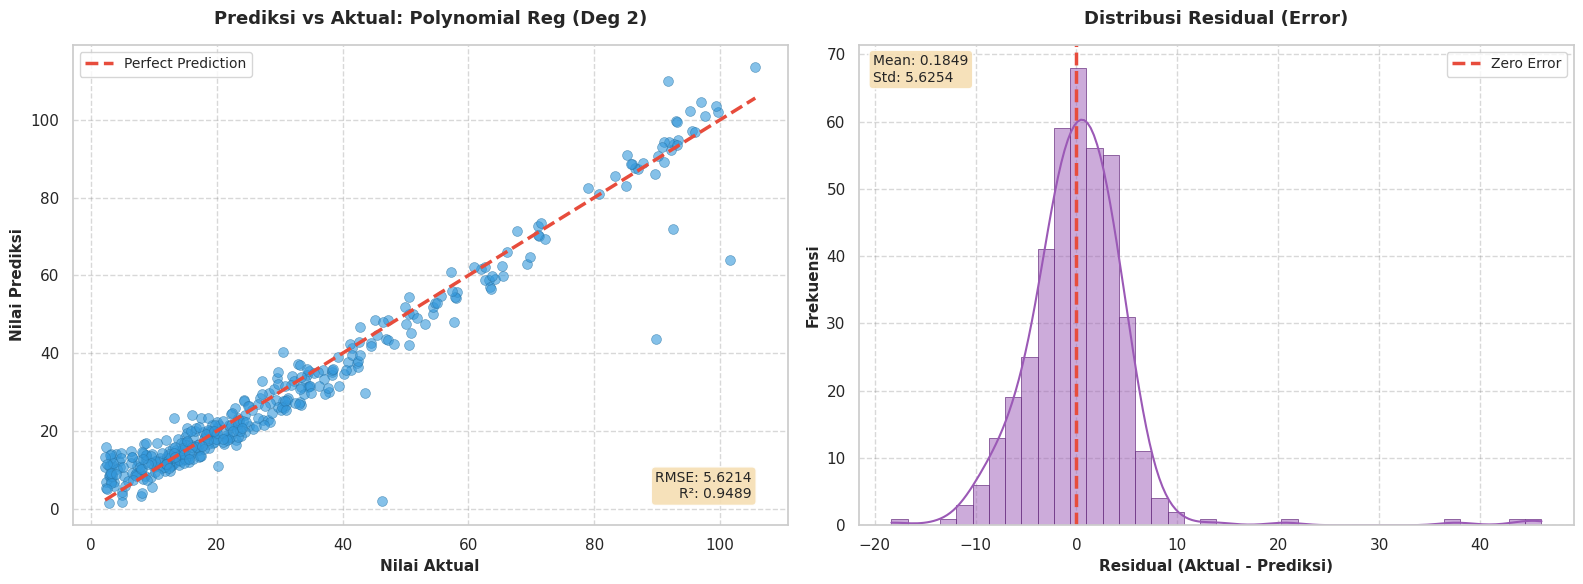


Statistik Residual:
  Mean Residual: 0.1849
  Std Residual: 5.6254
  Min Residual: -18.3441
  Max Residual: 46.0974


In [36]:
best_model_name = df_final.iloc[0]["Model"]
best_model_rmse = df_final.iloc[0]["RMSE"]
best_model_r2 = df_final.iloc[0]["R2 Score"]
best_model = trained_models[best_model_name]

y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

print(f"\n{'='*60}")
print(f"ANALISIS MODEL TERBAIK: {best_model_name}")
print(f"{'='*60}")
print(f"RMSE: {best_model_rmse:.4f}")
print(f"R² Score: {best_model_r2:.4f}")
print(f"{'='*60}\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test, y_pred_best, alpha=0.6, s=50, color='#3498DB', edgecolors='#2874A6', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='#E74C3C', linestyle='--', linewidth=2.5, label='Perfect Prediction')

axes[0].set_title(f"Prediksi vs Aktual: {best_model_name}", fontsize=13, fontweight='bold', pad=15)
axes[0].set_xlabel("Nilai Aktual", fontsize=11, fontweight='bold')
axes[0].set_ylabel("Nilai Prediksi", fontsize=11, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.3, color='gray')
axes[0].set_axisbelow(True)

rmse_text = f"RMSE: {best_model_rmse:.4f}\nR²: {best_model_r2:.4f}"
axes[0].text(0.95, 0.05, rmse_text, transform=axes[0].transAxes,
             fontsize=10, verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

sns.histplot(residuals, bins=40, kde=True, color='#9B59B6', ax=axes[1], edgecolor='#6C3483', linewidth=0.5)
axes[1].axvline(0, color='#E74C3C', linestyle='--', linewidth=2.5, label='Zero Error')

axes[1].set_title("Distribusi Residual (Error)", fontsize=13, fontweight='bold', pad=15)
axes[1].set_xlabel("Residual (Aktual - Prediksi)", fontsize=11, fontweight='bold')
axes[1].set_ylabel("Frekuensi", fontsize=11, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.3, color='gray')
axes[1].set_axisbelow(True)

mean_residual = residuals.mean()
std_residual = residuals.std()
stats_text = f"Mean: {mean_residual:.4f}\nStd: {std_residual:.4f}"
axes[1].text(0.02, 0.98, stats_text, transform=axes[1].transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='left',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

plt.tight_layout()
plt.show()

print("\nStatistik Residual:")
print(f"  Mean Residual: {mean_residual:.4f}")
print(f"  Std Residual: {std_residual:.4f}")
print(f"  Min Residual: {residuals.min():.4f}")
print(f"  Max Residual: {residuals.max():.4f}")